# Lab Deep Learning / Multi-Layer Perceptron for regression / in pytorch

**Author: geoffroy.peeters@telecom-paris.fr**

For any remark or suggestion, please feel free to contact me.

Last edits:
- 2020/03/24 peeters (change dimensions order)
- 2020/04/27 peeters (added comments on W1, W2 initialization, added comments on A and B)
- 2021/05/05 peeters (add some documentation related to ```W1 -= ...```)
- 2023/05/10 peeters (typos corrections)
- 2024/05/02 peeters (link to do nn.Linear)

Read the "introduction to pytorch"
- slides: https://perso.telecom-paristech.fr/gpeeters/doc/pytorch/
- video: https://perso.telecom-paristech.fr/gpeeters/video/pytorch.mp4


## Objective:

The objective of this lab is to demonstrate the use of Neural Networks to perform non-linear regression.
We will use a simple NN with 1 hidden layer. The hidden layer has $n_h$ (you will test various values of $n_h$) hidden units and either a ```sigmoid```, ```relu``` or ```tanh``` activation.
Since we perform a regression task the output $\hat{y} \in \mathbb{R}$ and  there is no output activation (linear).

You will perform 1000 iterations (epochs) of SGD to find the parameters.

You will then apply the network to the two datasets A and B.

Note: for this lab, we do not separate the dataset into a train, validation and test part. We simply check the ```capacity``` of the network to model the training data.

**Question**: according to the obtained loss, discuss the choice of ```sigmoid```, ```relu``` or ```tanh```.



### Data normalization

You should normalize the data to zero mean and unit standard deviation

### Model

There are various ways to write a NN model in pytorch.

In this lab, you will write three different implementations:
- **Model A**: manually defining the parameters (W1,b1,w2,b2), writting the forward equations, writting the loss equation, calling the .backward() and manually updating the weights using W1.grad. You will write the loop to perform 1000 epochs.
- **Model B**: using the Sequential class of pytorch
- **Model C**: a custom torch.nn.Module class for this.

For Model B and C, you will use the ready made loss and optimization from the nn and optim packages. You can use the same code to optimize the parameters of Model B and C.

### Loss

Since we are dealing with a regression problem, we will use a Mean Square Error loss: write it by-hand for Model A and use ```torch.nn.MSELoss``` for Model B and C.

### Parameters update/ Optimization

For updating the parameters, we will use as optimizer a simple SGD algorithm (use ```torch.optim.SGD``` for Model B and C) with a learning rate of 0.05.

Don't forget that an optimizer is applied to a set of parameters (```my_model.parameters()``` gives the parameters of the network for Model B and C).
Once the gradients have been computed (after the backpropagation has been performed), you can perform one step of optimization (using ```optimizer.step()``` for Model B and C).

### Backward propagation

Backpropagation is automatically performed in pytorch using the ```autograd``` package.
First, reset the gradients of all parameters (using ```optimizer.zero_grad()``` for Model B and C), then perform the backpropagation ```loss.backward()```.

### Regularization

- How can you add a Ridge (L2) regularization ? this can be done easely within the definition of the ```optimizer```.
- How can you add a Lasso (L1) regularization ? this has to be done manually at each iteration, by adding something to the loss before backpropagation.

**Question**: discuss the use of the Ridge and Lasso regularization for each dataset.

## Your task:

You need to add the missing parts in the code (parts between ```# --- START CODE HERE``` and ```# --- END CODE HERE```)

## Load the python packages

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

## Datasets

We will use two different datasets. For both $x$ has dimensions $(m,n_{in}=1)$ and $y$ has dimensions $(m,n_{out}=1)$ where $m$ is the number of examples.



In [2]:
def F_do_dataset_parab(m):
    x_data = torch.linspace(-1, 1, m)
    noise_data = 0.2*torch.rand(m)
    y_data = x_data.pow(2) + noise_data

    # --- change vectos to matrix
    x_data = torch.unsqueeze(x_data, dim=1)
    y_data = torch.unsqueeze(y_data, dim=1)
    return x_data, y_data

def F_do_dataset_sin(m):
    x_data = torch.arange(0, m, dtype=torch.float32)
    noise_data = 0.2*torch.rand(m)
    y_data = torch.sin(2*np.pi*x_data*0.001) + noise_data

    # --- change vectos to matrix
    x_data = torch.unsqueeze(x_data, dim=1)
    y_data = torch.unsqueeze(y_data, dim=1)
    return x_data, y_data

size of x_data: torch.Size([3000, 1])
size of y_data: torch.Size([3000, 1])


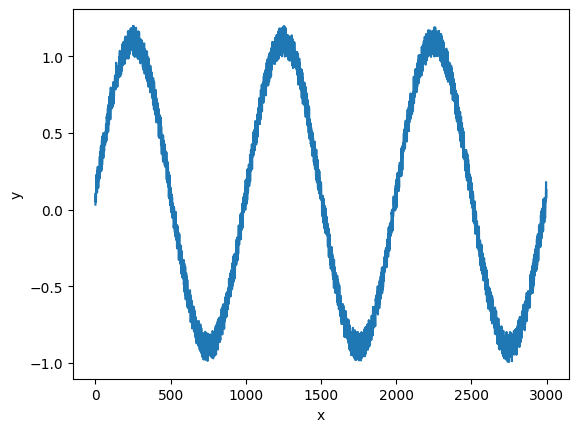

In [3]:
# --- Dataset 1
#x_data, y_data = F_do_dataset_parab(m=100)
# --- Dataset 2
x_data, y_data = F_do_dataset_sin(m=3000)

plt.plot(x_data.numpy(), y_data.numpy());
plt.xlabel('x'), plt.ylabel('y');

print('size of x_data:', x_data.size())
print('size of y_data:', y_data.size())

## Data standardization

We standardize the input data (substract mean and divide by standard-deviation)

In [4]:
# --- START CODE HERE
x_data = (x_data - x_data.mean()) / x_data.std()
y_data = (y_data - y_data.mean()) / y_data.std()
# --- END CODE HERE

## Hyper-parameters definition

In [5]:
n_in = 1
n_h = 10
n_out = 1

nb_epoch = 20000
learning_rate_alpha = 0.05
param_momentum = 0.01
param_L1_weight = 0.001
param_L2_weight = 0.01

## Model A (writting the network equations)

For model A, you will define the variables and write the equations of the network yourself (as you would do in numpy).
However you will use ```torch tensors``` instead of ```numpy array```.

***Why ?*** because torch tensors will allows you to automatically get the gradient. You will use ```loss.backward()``` to launch the backpropagation from the ```loss``` variable.
Then, for all torch tensors you have created and for which you have declared ```requires_grad=True```, you will get the gradient of ```loss```with respect to this variable in the field ```.grad```.

***Example*** ```W1 = torch.tensors(..., requires_grad=True)``` ... ```loss.backward()``` will have the gradient $\frac{d Loss}{d W1}$in ```W1.grad```.

### Initialize the variables

**Note**: In order to avoid neuron saturation and that all the neurons learn the same thing, the matrix should be initialized to a small random value (see https://pytorch.org/docs/stable/generated/torch.nn.Linear.html for details). Because of this, W1 and W2 should be first define as small random; **then** set to ```requires_grad=True```.

In [10]:
# --- START CODE HERE
W1 = torch.randn(n_in, n_h) * 0.01  # small random values for W1
b1 = torch.zeros(1, n_h)  # initialize b1 as zeros
W2 = torch.randn(n_h, n_out) * 0.01  # small random values for W2
b2 = torch.zeros(1, n_out)  # initialize b2 as zeros

# Set requires_grad to True for backpropagation
W1.requires_grad_(True)
b1.requires_grad_(True)
W2.requires_grad_(True)
b2.requires_grad_(True)
# --- END CODE HERE

tensor([[0.]], requires_grad=True)

### Define the model

We will denote by ```H``` the pre-activation (value before the non-linearity) and by ```A``` the activation (value after the non-linearity).

In [11]:
def model(X):

    # --- START CODE HERE
    # --- H is the result of the first projection
    H = X.mm(W1) + b1  # XW1 + b1

    # --- H is then transformed by a non-linearity to A
    A = torch.sigmoid(H)  # You can replace torch.sigmoid with torch.relu or torch.tanh depending on the activation function you want to test

    # Final output prediction
    y_pred = A.mm(W2) + b2  # AW2 + b2
    # --- END CODE HERE
    return y_pred

### Train the model

**Note**: when updating the parameters (W1,b1,W2,b2) you should use an "in-place" update: ```W1 -= ...``` instead of ```W1 = W1 - ...```; otherwise ```W1``` will be replaced by its value and its gradient field will not exist anymore.

In [8]:
learning_rate_alpha=0.05

In [13]:
for epoch in range(0, nb_epoch):
    # --- Forward pass: compute predicted y
    y_pred = model(x_data)

    # --- Compute the loss (Mean Squared Error)
    loss = torch.mean((y_pred - y_data) ** 2)

    # --- Perform backpropagation
    loss.backward()

    with torch.no_grad():
        # --- Update weights and biases in-place
        W1 -= learning_rate_alpha * W1.grad
        b1 -= learning_rate_alpha * b1.grad
        W2 -= learning_rate_alpha * W2.grad
        b2 -= learning_rate_alpha * b2.grad

        # --- Zero the gradients after updating
        W1.grad.zero_()
        b1.grad.zero_()
        W2.grad.zero_()
        b2.grad.zero_()

    if epoch % 1000 == 0:
        print('epoch {}, loss {}'.format(epoch, loss.item()))


epoch 0, loss 0.9996121525764465
epoch 1000, loss 0.9351099729537964
epoch 2000, loss 0.934647798538208
epoch 3000, loss 0.934380292892456
epoch 4000, loss 0.934207022190094
epoch 5000, loss 0.934086263179779
epoch 6000, loss 0.9339973330497742
epoch 7000, loss 0.9339291453361511
epoch 8000, loss 0.9338751435279846
epoch 9000, loss 0.9338313937187195
epoch 10000, loss 0.9337950944900513
epoch 11000, loss 0.9337642192840576
epoch 12000, loss 0.9337376952171326
epoch 13000, loss 0.9337142705917358
epoch 14000, loss 0.9336937069892883
epoch 15000, loss 0.9336749911308289
epoch 16000, loss 0.9336581230163574
epoch 17000, loss 0.9336426854133606
epoch 18000, loss 0.9336285591125488
epoch 19000, loss 0.9336155652999878


### Plotting the results

We will super-impose the biases of the first layer to better understand how the model has fit the sinusoidal curve. Please explain what it does.

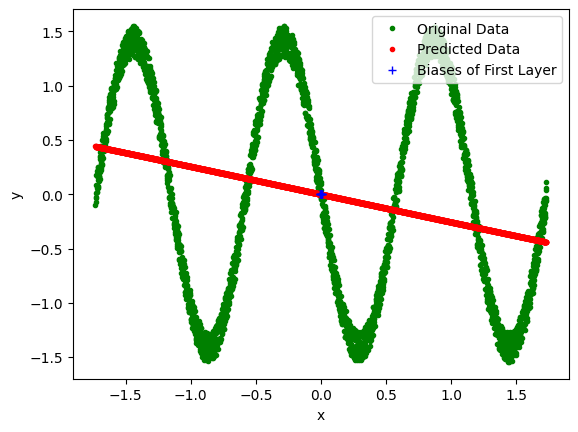

In [15]:
# Flatten the b1 tensor
b1_flat = b1.detach().numpy().flatten()

# Plotting the results
plt.plot(x_data.numpy(), y_data.numpy(), 'g.', label='Original Data')
plt.plot(x_data.numpy(), y_pred.detach().numpy(), 'r.', label='Predicted Data')
# Super-impose the biases of the first layer
plt.plot(b1_flat, np.zeros_like(b1_flat), 'b+', label='Biases of First Layer')

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


## Model B (using Sequential class)

Here, you will write the network using the nn.Sequential class.
With this you can use the ready-made layers ``torch.nn.Linear``,``torch.nn.Tanh``, ...

In [16]:
# --- START CODE HERE
model_B = nn.Sequential(
    nn.Linear(n_in, n_h),  # First linear layer: input to hidden layer
    nn.Tanh(),             # Non-linearity (you can replace this with ReLU, Sigmoid, etc.)
    nn.Linear(n_h, n_out)  # Second linear layer: hidden layer to output layer
)
# --- END CODE HERE

## Model C (using a class definition)

Here, you will write the network using the recommended pytorch way; i.e. by defining a class.
This class inherit from the main class ```torch.nn.Module```.
You only need to write the ```__init__``` method and the ```forward``` method.

In object programming, the ```__init__``` method defines the attributes of your class. Since the attributes of your  network are the parameters to be trained (weights and biases), you should declare in the ```__init``` all the layers that involve parameters to be trained (mostly the ```Linear```layers which perform the matrix multiplication).

The ```forward``` method contains the code of the forward pass itself. It can of course call attributes defined in the ```__init___``` method. It is the method used when calling ```model(x)```.

As before, the model created will have all its parameters accessible as a dictionary and can be accessed using ```model.parameters()```.

Classes are convenient way to write more complex network than what you can do with ```nn.sequential```. Note that you can actually include a ```nn.sequential``` in your class.

In [17]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # --- START CODE HERE
        # Define the layers of the network
        self.fc1 = nn.Linear(n_in, n_h)  # First linear layer
        self.activation = nn.Tanh()      # Activation function (can replace with nn.ReLU(), nn.Sigmoid(), etc.)
        self.fc2 = nn.Linear(n_h, n_out) # Second linear layer
        # --- END CODE HERE

    def forward(self, x):

        # --- START CODE HERE
        # Define the forward pass
        H = self.fc1(x)        # First projection (linear transformation)
        A = self.activation(H) # Apply activation function
        y_pred = self.fc2(A)   # Second projection (linear transformation)
        # --- END CODE HERE

        return y_pred

# --- START CODE HERE
# --- Initialize the model
model_C = Net()
# --- END CODE HERE

## Model B+C

### Criterion and Optimization

The code of Model A is self-contained, i.e. it already contains all necessary instruction to perform forward, loss, backward and parameter updates.

When using ```nn.sequential``` (model B) or a class definition of the network (model C), we still need to define
- what we will minimize (the loss to be minimized, i.e. Mean-Square-Error or Binary-Cross-Entropy). We can of course write the equation of it by hand but pytorch comes with a very large number of pre-build loss functions (within ```torch.nn```)
- how we will minimize the loss, i.e. what parameter update alogirhtms we will use (SGD, momentum). We can of course write the equation of it by hand but pytorch comes with a very large number of pre-build loss functions (within ```torch.nn```)

L2 regularization can be done directly in the optimizer under the name ```weight_decay```.

In [18]:
# --- START CODE HERE
# Define the loss function
criterion = nn.MSELoss()

# Define the optimizer for Model B and Model C
optimizer_B_C = optim.SGD(model_B.parameters(),
                          lr=learning_rate_alpha,
                          momentum=param_momentum,
                          weight_decay=param_L2_weight)
# --- END CODE HERE

### Training

Having defined the network, the citerion to be minimized and the optimizer, we then perform a loop over epochs (iterations); at each step we
- compute the forward pass by passing the data to the model: ```haty = model(x)```
- compute the the loss (the criterion)
- putting at zero the gradients of all the parameters of the network (this is important since, by default, pytorch accumulate the gradients over time)
- computing the backpropagation (using as before ```.backward()```)
- performing one step of optimization (using ```.step()```)

In [19]:
loss_l = []
for epoch in range(nb_epoch):

    # --- START CODE HERE
    # --- Forward pass: compute predicted y
    y_pred = model_B(x_data)  # Replace with model_C(x_data) if using Model C

    # --- Compute the loss (Mean Squared Error)
    loss = criterion(y_pred, y_data)

    # --- Zero the gradients before backward pass
    optimizer_B_C.zero_grad()

    # --- Backward pass: compute the gradients
    loss.backward()

    # --- Perform optimization step
    optimizer_B_C.step()

    # Store loss for this epoch
    loss_l.append(loss.item())
    # --- END CODE HERE

    if epoch % 1000 == 0:
        print('epoch {}, loss {}'.format(epoch, loss.item()))

epoch 0, loss 1.253474473953247
epoch 1000, loss 0.9186621904373169
epoch 2000, loss 0.8802968859672546
epoch 3000, loss 0.8745096325874329
epoch 4000, loss 0.8727648258209229
epoch 5000, loss 0.8721801042556763
epoch 6000, loss 0.8719778656959534
epoch 7000, loss 0.8719070553779602
epoch 8000, loss 0.8718823194503784
epoch 9000, loss 0.8718735575675964
epoch 10000, loss 0.8718703389167786
epoch 11000, loss 0.8718696236610413
epoch 12000, loss 0.8718694448471069
epoch 13000, loss 0.8718694448471069
epoch 14000, loss 0.8718693852424622
epoch 15000, loss 0.8718693256378174
epoch 16000, loss 0.8718694448471069
epoch 17000, loss 0.8718694448471069
epoch 18000, loss 0.8718694448471069
epoch 19000, loss 0.8718695640563965


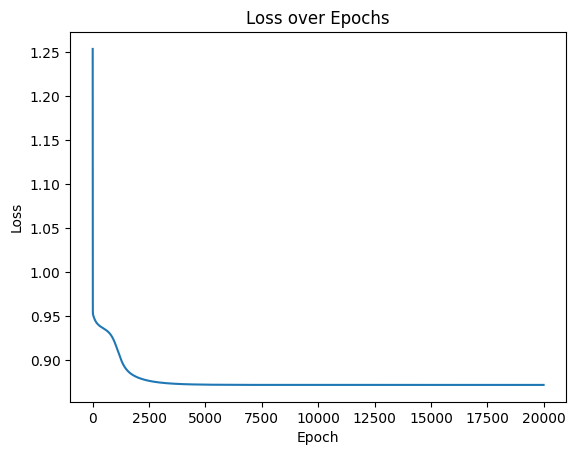

In [23]:
# Plot loss over epochs
plt.figure()
plt.plot(loss_l)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.show()

### Plotting results

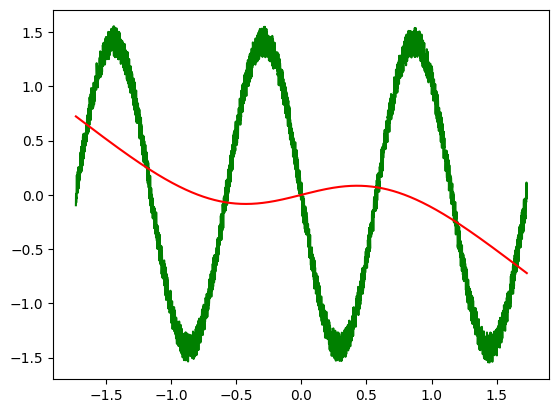

In [21]:
# ----------------
plt.plot(x_data.numpy(), y_data.numpy(), 'g')
plt.plot(x_data.numpy(), y_pred.detach().numpy(), 'r')

### Display the weights and the biases

Now, we want to check the effect of L1 regularization. For this you will plot the values of the weights of each layers.

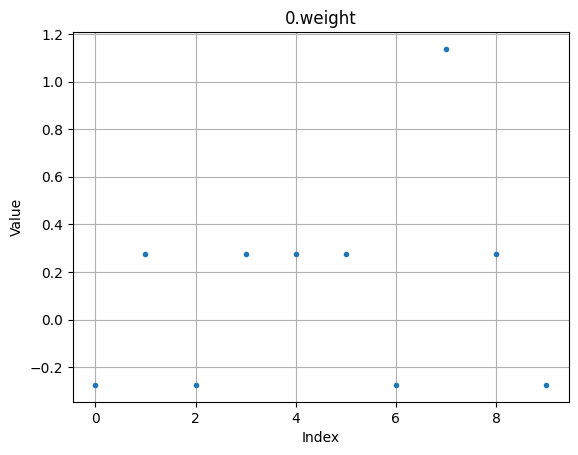

0.weight:
[[-0.2748513 ]
 [ 0.2748397 ]
 [-0.27484816]
 [ 0.2748408 ]
 [ 0.2748406 ]
 [ 0.27485216]
 [-0.27484354]
 [ 1.1372899 ]
 [ 0.27484104]
 [-0.27484   ]]


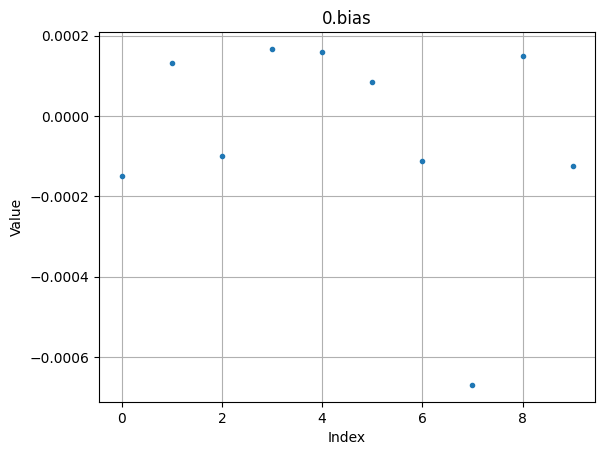

0.bias:
[-1.5031261e-04  1.3154067e-04 -9.8682693e-05  1.6676052e-04
  1.5965148e-04  8.3162326e-05 -1.1234790e-04 -6.6978240e-04
  1.4892874e-04 -1.2465398e-04]


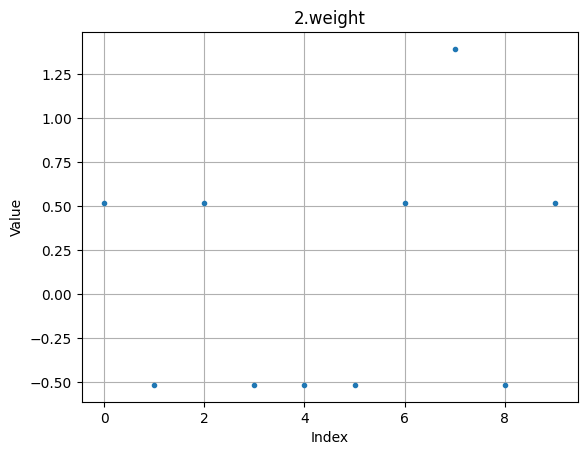

2.weight:
[[ 0.5171859  -0.5170806   0.5171719  -0.51708144 -0.51707995 -0.5171916
   0.5171217   1.3923355  -0.517079    0.51708066]]


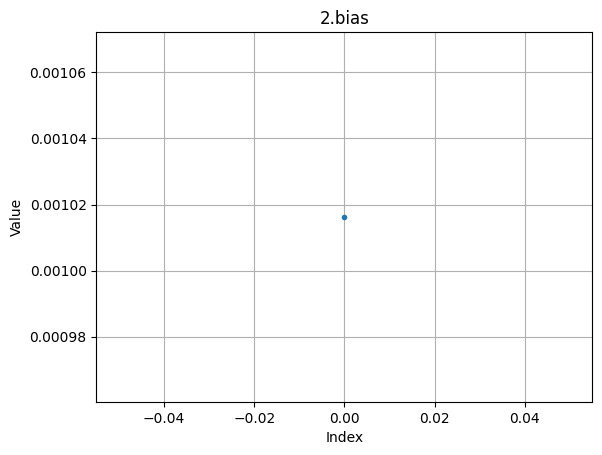

2.bias:
[0.00101625]


In [25]:
# Collect and plot weights and biases
list_l = [{'name': name, 'data': layer} for name, layer in model_B.named_parameters()]  # Use model_C if you are using Model C

for tmp in list_l:
    plt.figure()
    plt.plot(tmp['data'].flatten().detach().numpy(), '.')
    plt.title(tmp['name'])
    plt.grid(True)
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.show()  # Show plot for each parameter
    print(f"{tmp['name']}:\n{tmp['data'].detach().numpy()}")
